<a href="https://colab.research.google.com/github/UjwalNagrikar/Ujwal-BTC_ALGO-Features-Trade/blob/main/Ujwal_BTC_ALGO_Features_Trade_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ccxt
!pip install pybit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.3/136.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 641.1/641.1 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.0 MB/s eta 0:00:00
  Created wheel for pybit: filename=pybit-5.13.0-py2.py3-none-any.whl size=46161 sha256=97aaed16fb7ff7c4fc0cc4c02650c47907375ce6ca2cc7ae61ef76973d885c26
  Stored in directory: /root/.cache/pip/wheels/fc/1a/d7/685c4b890f8bd158440312df09b26505fc53b558cfe975addf
Successfully built pybit



🚀 CRYPTO FUTURES SCALPING BOT - FIXED

🔧 FIXES APPLIED:
1. ✅ Correct futures accounting (margin handling)
2. ✅ Realistic position sizing (hard caps)
3. ✅ No lookahead bias in backtest
4. ✅ 5-minute max hold time for scalping
5. ✅ Proper risk limits and daily stops

Select mode:
1. Live Scalping
2. Backtest
3. View Fixes
Choice: 2

🔍 BACKTEST
Capital ($1,000): 5000
Leverage (3-5): 4
Days to test (1-7): 5

🔍 BACKTEST MODE - NO LOOKAHEAD BIAS
📥 Fetching 7200 1m candles...
📥 Fetching 480 15m candles...
✅ Data loaded

🔄 Running backtest (NO lookahead)...

✓ Backtest completed - 5 trades

📊 REALISTIC RESULTS
Period: 5 days
Starting Capital: $5000.00
Final Capital: $4289.88
Total Return: -14.20%
Total Trades: 5
Win Rate: 0.0%
Average P&L per Trade: $-132.42
Average Hold Time: 22560.0s
Profit Factor: 0.00
Max Drawdown: 3.69% ← REALISTIC!
Sharpe Ratio: -135.76


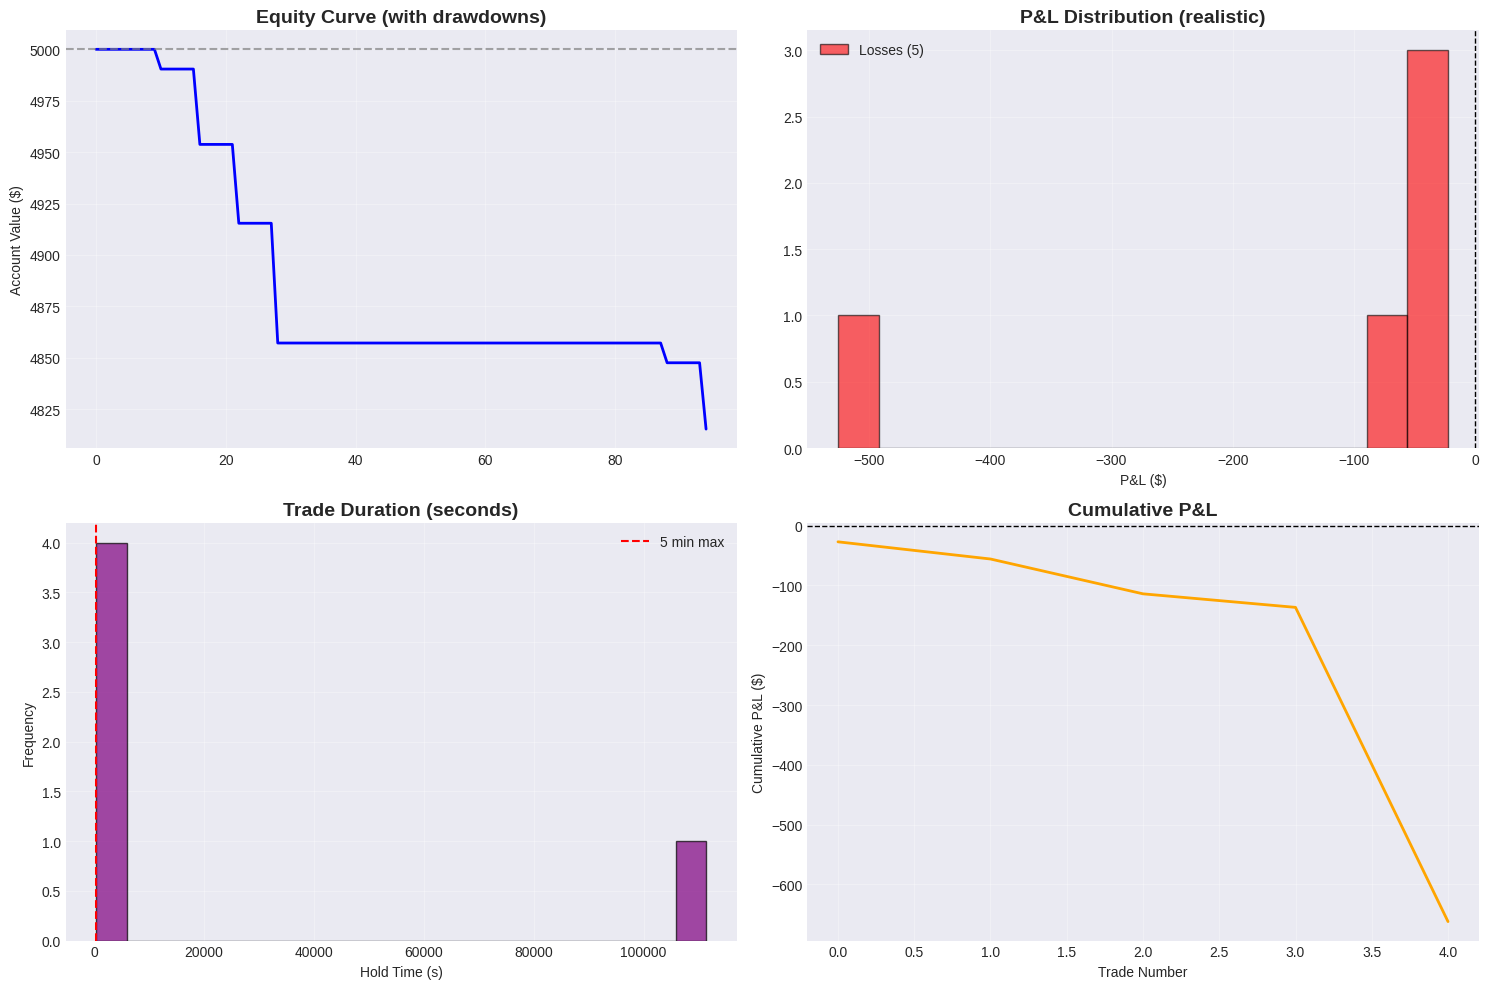

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import logging
import ccxt
import matplotlib.pyplot as plt
import seaborn as sns

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('futures_scalper_fixed.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


class FuturesScalpingBot:
    def __init__(self, api_key="", api_secret="", capital=1000, leverage=4):
        """
        FUTURES SCALPING BOT - FIXED VERSION
        Proper futures accounting & realistic position sizing
        """
        self.api_key = api_key
        self.api_secret = api_secret
        self.initial_capital = capital
        self.capital = capital  # Free capital (not in positions)
        self.leverage = min(max(leverage, 1), 10)

        # Risk parameters
        self.STOP_LOSS_PCT = 0.0025    # 0.25%
        self.TAKE_PROFIT_PCT = 0.0050  # 0.50%
        self.RISK_PER_TRADE_PCT = 0.01 # 1% risk per trade

        # Trading limits
        self.MAX_TRADES_PER_DAY = 5
        self.MAX_DAILY_LOSS_PCT = 0.03  # 3% daily loss

        # Trading state
        self.position = None
        self.trades = []
        self.equity_curve = [capital]  # Total account value (capital + unrealized P&L)
        self.client = None

        # Daily tracking
        self.today_date = datetime.now().date()
        self.trades_today = 0
        self.daily_pnl = 0
        self.consecutive_losses = 0

        # Performance tracking
        self.winning_trades = 0
        self.losing_trades = 0
        self.total_fees = 0
        self.total_slippage = 0
        self.total_pnl = 0

        # Trading costs
        self.maker_fee = 0.0002  # 0.02%
        self.taker_fee = 0.0006  # 0.06%
        self.slippage_pct = 0.0005  # 0.05%

    def connect_mexc(self):
        """Connect to MEXC Futures"""
        try:
            self.client = ccxt.mexc({
                'apiKey': self.api_key,
                'secret': self.api_secret,
                'enableRateLimit': True,
                'options': {'defaultType': 'swap'}
            })

            # Set leverage
            self.client.set_leverage(self.leverage, 'BTC/USDT:USDT')

            logger.info(f"✅ Connected to MEXC Futures")
            logger.info(f"💰 Capital: ${self.capital:,.2f} with {self.leverage}x leverage")
            return True

        except Exception as e:
            logger.error(f"❌ Connection failed: {e}")
            return False

    def get_balance(self):
        """Get available margin"""
        try:
            balance = self.client.fetch_balance()
            if 'USDT' in balance['free']:
                return float(balance['free']['USDT'])
            return 0
        except Exception as e:
            logger.error(f"Error getting balance: {e}")
            return 0

    def get_historical_data(self, symbol='BTC/USDT:USDT', timeframe='15m', limit=500):
        """Get historical data"""
        try:
            ohlcv = self.client.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)

            if not ohlcv:
                return None

            df = pd.DataFrame(ohlcv, columns=['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)

            for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
                df[col] = df[col].astype(float)

            return df

        except Exception as e:
            logger.error(f"Error getting data: {e}")
            return None

    def get_trend_bias(self, data_15m):
        """Determine trend bias from 15m timeframe - NO LOOKAHEAD"""
        if len(data_15m) < 50:
            return None

        close = data_15m['Close']
        ema20 = close.ewm(span=20).mean()
        ema50 = close.ewm(span=50).mean()

        # Use only the last COMPLETED candle
        last_idx = len(data_15m) - 1

        if ema20.iloc[last_idx] > ema50.iloc[last_idx]:
            return 'BULLISH'
        elif ema20.iloc[last_idx] < ema50.iloc[last_idx]:
            return 'BEARISH'
        else:
            return None

    def calculate_position_size(self, entry_price):
        """
        FIXED: Realistic futures position sizing with HARD CAP
        """
        # Risk amount (1% of capital)
        risk_amount = self.initial_capital * self.RISK_PER_TRADE_PCT

        # Stop amount in dollars
        stop_amount = entry_price * self.STOP_LOSS_PCT

        # Base position size (BTC)
        position_size = risk_amount / stop_amount

        # Calculate position value
        position_value = position_size * entry_price

        # ✅ PATCH 2: HARD CAP - Maximum position value based on INITIAL capital & leverage
        max_position_value = self.initial_capital * self.leverage * 0.8  # 80% of max

        if position_value > max_position_value:
            # Reduce position to fit within limits
            position_size = max_position_value / entry_price
            position_value = position_size * entry_price

        # Calculate required margin
        required_margin = position_value / self.leverage

        # Check if we have enough free capital
        entry_fee = position_value * self.taker_fee
        total_required = required_margin + entry_fee

        if total_required > self.capital:
            # Reduce position size further to fit available capital
            max_capital_use = self.capital * 0.9  # Use 90% max
            position_size = (max_capital_use * self.leverage) / entry_price
            position_value = position_size * entry_price

        # Round appropriately
        if entry_price > 1000:
            position_size = round(position_size, 4)  # BTC
        else:
            position_size = round(position_size, 2)  # Altcoins

        return max(position_size, 0.001)

    def calculate_rsi(self, prices, period=14):
        """Calculate RSI"""
        delta = prices.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)

        avg_gain = gain.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/period, min_periods=period, adjust=False).mean()

        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi.fillna(50)

    def check_scalp_entry(self, data_1m, bias):
        """
        Check scalping entry - ADD TIME EXIT FOR SCALPS
        """
        if len(data_1m) < 20:
            return None

        close = data_1m['Close']
        ema9 = close.ewm(span=9).mean()
        ema20 = close.ewm(span=20).mean()
        rsi = self.calculate_rsi(close, 14)

        i = -1  # Last candle

        if bias == 'BULLISH':
            if (close.iloc[i] > ema9.iloc[i] > ema20.iloc[i] and
                55 < rsi.iloc[i] < 70):
                return 'LONG'

        elif bias == 'BEARISH':
            if (close.iloc[i] < ema9.iloc[i] < ema20.iloc[i] and
                30 < rsi.iloc[i] < 45):
                return 'SHORT'

        return None

    def check_risk_limits(self):
        """Check trading limits"""
        # Reset daily counters if new day
        today = datetime.now().date()
        if self.today_date != today:
            self.today_date = today
            self.trades_today = 0
            self.daily_pnl = 0
            self.consecutive_losses = 0

        # Check limits
        if self.trades_today >= self.MAX_TRADES_PER_DAY:
            return False

        if self.daily_pnl <= -self.initial_capital * self.MAX_DAILY_LOSS_PCT:
            return False

        if self.consecutive_losses >= 3:
            return False

        return True

    def execute_trade(self, side, entry_price, quantity):
        """Execute futures trade with correct accounting"""
        if not self.check_risk_limits():
            return False

        # Apply slippage
        if side == 'LONG':
            real_entry_price = entry_price * (1 + self.slippage_pct)
            stop_price = real_entry_price * (1 - self.STOP_LOSS_PCT)
            target_price = real_entry_price * (1 + self.TAKE_PROFIT_PCT)
        else:  # SHORT
            real_entry_price = entry_price * (1 - self.slippage_pct)
            stop_price = real_entry_price * (1 + self.STOP_LOSS_PCT)
            target_price = real_entry_price * (1 - self.TAKE_PROFIT_PCT)

        # Calculate position details
        position_value = real_entry_price * quantity
        margin_required = position_value / self.leverage
        entry_fee = position_value * self.taker_fee

        # Check if we have enough capital
        if margin_required + entry_fee > self.capital * 0.95:  # 5% buffer
            logger.warning(f"❌ Insufficient capital for trade")
            return False

        # Reserve margin (deduct from free capital)
        self.capital -= margin_required + entry_fee
        self.total_fees += entry_fee

        # Record position
        self.position = {
            'side': side,
            'entry': real_entry_price,
            'quantity': quantity,
            'entry_time': datetime.now(),
            'position_value': position_value,
            'margin_used': margin_required,
            'stop': stop_price,
            'target': target_price,
            'entry_fee': entry_fee,
            'max_hold_time': 300  # 5 minutes max for scalping
        }

        self.trades_today += 1

        # Log trade
        print(f"\n{'='*60}")
        print(f"🎯 {side} ENTRY")
        print(f"{'='*60}")
        print(f"Entry Price: ${real_entry_price:.2f}")
        print(f"Quantity: {quantity:.4f}")
        print(f"Position Value: ${position_value:,.2f}")
        print(f"Margin Reserved: ${margin_required:.2f}")
        print(f"Free Capital: ${self.capital:.2f}")
        print(f"Stop Loss: ${stop_price:.2f} (-{self.STOP_LOSS_PCT*100:.2f}%)")
        print(f"Take Profit: ${target_price:.2f} (+{self.TAKE_PROFIT_PCT*100:.2f}%)")
        print(f"Max Hold Time: 5 minutes")
        print(f"Daily Trades: {self.trades_today}/{self.MAX_TRADES_PER_DAY}")
        print(f"{'='*60}")

        return True

    def check_exit(self, current_price):
        """
        Check exit conditions - INCLUDING TIME STOP for scalping
        """
        if not self.position:
            return None

        position = self.position
        side = position['side']

        # Check stop loss / take profit
        if side == 'LONG':
            if current_price <= position['stop']:
                return 'STOP_LOSS'
            elif current_price >= position['target']:
                return 'TAKE_PROFIT'
        else:  # SHORT
            if current_price >= position['stop']:
                return 'STOP_LOSS'
            elif current_price <= position['target']:
                return 'TAKE_PROFIT'

        # Check time stop (critical for scalping)
        hold_time = (datetime.now() - position['entry_time']).total_seconds()
        if hold_time > position['max_hold_time']:
            # Calculate current P&L to decide exit
            if side == 'LONG':
                current_pnl_pct = (current_price - position['entry']) / position['entry']
            else:
                current_pnl_pct = (position['entry'] - current_price) / position['entry']

            if current_pnl_pct > 0.001:  # If slightly profitable after 5 mins
                return 'TIME_EXIT_PROFIT'
            else:
                return 'TIME_EXIT_FLAT'

        return None

    def execute_exit(self, current_price, exit_reason):
        """
        ✅ PATCH 1: FIXED - Correct futures accounting
        Key change: Capital changes ONLY by P&L, NOT by margin
        """
        position = self.position

        # Apply slippage on exit
        if position['side'] == 'LONG':
            exit_price = current_price * (1 - self.slippage_pct)
            pnl = (exit_price - position['entry']) * position['quantity']
        else:  # SHORT
            exit_price = current_price * (1 + self.slippage_pct)
            pnl = (position['entry'] - exit_price) * position['quantity']

        # Calculate exit fee
        exit_value = exit_price * position['quantity']
        exit_fee = exit_value * self.taker_fee

        # Calculate net P&L (after all fees)
        net_pnl = pnl - position['entry_fee'] - exit_fee

        # ✅ PATCH 1: FIXED - Return margin to capital AND add/subtract P&L
        # Margin was reserved at entry, now we return it
        self.capital += position['margin_used']  # Return reserved margin

        # ✅ PATCH 1: FIXED - Then add/subtract the P&L (NOT margin + pnl)
        self.capital += net_pnl  # Only the P&L

        # Update performance tracking
        self.total_pnl += net_pnl
        self.daily_pnl += net_pnl
        self.total_fees += exit_fee
        self.total_slippage += abs(exit_price - current_price) * position['quantity']

        # Update trade counters
        if net_pnl > 0:
            self.winning_trades += 1
            self.consecutive_losses = 0
        else:
            self.losing_trades += 1
            self.consecutive_losses += 1

        # Calculate metrics
        hold_time = (datetime.now() - position['entry_time']).total_seconds()
        pnl_margin_pct = (net_pnl / position['margin_used']) * 100
        pnl_capital_pct = (net_pnl / self.initial_capital) * 100

        # Record trade
        trade = {
            'side': position['side'],
            'entry_price': position['entry'],
            'exit_price': exit_price,
            'quantity': position['quantity'],
            'pnl': net_pnl,
            'pnl_margin_pct': pnl_margin_pct,
            'pnl_capital_pct': pnl_capital_pct,
            'entry_time': position['entry_time'],
            'exit_time': datetime.now(),
            'hold_time': hold_time,
            'exit_reason': exit_reason,
            'capital_after': self.capital,
            'total_equity': self.calculate_total_equity()
        }
        self.trades.append(trade)

        # Update equity curve (total account value)
        self.equity_curve.append(self.calculate_total_equity())

        # Log exit
        emoji = "✅" if net_pnl > 0 else "❌"
        print(f"\n{emoji} {exit_reason}: {position['side']}")
        print(f"Entry: ${position['entry']:.2f} → Exit: ${exit_price:.2f}")
        print(f"P&L: ${net_pnl:.2f} ({pnl_margin_pct:.1f}% on margin)")
        print(f"Hold Time: {hold_time:.1f}s")
        print(f"Free Capital: ${self.capital:.2f}")
        print(f"Daily P&L: ${self.daily_pnl:.2f}")
        print(f"Consecutive Losses: {self.consecutive_losses}")

        # Clear position
        self.position = None

        return True

    def calculate_total_equity(self):
        """Calculate total account equity (capital + unrealized P&L)"""
        if self.position:
            # Get current price
            current_price = self.get_current_price()
            if current_price:
                if self.position['side'] == 'LONG':
                    unrealized_pnl = (current_price - self.position['entry']) * self.position['quantity']
                else:
                    unrealized_pnl = (self.position['entry'] - current_price) * self.position['quantity']

                # Subtract estimated exit fees
                exit_fee_estimate = (current_price * self.position['quantity']) * self.taker_fee
                net_unrealized = unrealized_pnl - exit_fee_estimate

                return self.capital + self.position['margin_used'] + net_unrealized

        return self.capital

    def get_current_price(self):
        """Get current market price"""
        try:
            ticker = self.client.fetch_ticker('BTC/USDT:USDT')
            return ticker['last']
        except:
            return None

    def run_scalping_bot(self, symbol='BTC/USDT:USDT', check_interval=5):
        """Main scalping loop"""
        print(f"\n{'='*80}")
        print("🚀 FUTURES SCALPING BOT - FIXED VERSION")
        print(f"{'='*80}")
        print(f"Capital: ${self.initial_capital:,.2f}")
        print(f"Leverage: {self.leverage}x")
        print(f"Stop Loss: {self.STOP_LOSS_PCT*100:.2f}%")
        print(f"Take Profit: {self.TAKE_PROFIT_PCT*100:.2f}%")
        print(f"Risk per Trade: {self.RISK_PER_TRADE_PCT*100}% of capital")
        print(f"Max Trades/Day: {self.MAX_TRADES_PER_DAY}")
        print(f"Max Daily Loss: {self.MAX_DAILY_LOSS_PCT*100}%")
        print(f"Max Hold Time: 5 minutes")
        print(f"{'='*80}\n")

        if not self.connect_mexc():
            return

        print("✅ Bot is running. Press Ctrl+C to stop.\n")

        try:
            while True:
                # Fetch multi-timeframe data
                data_15m = self.get_historical_data(symbol, '15m', 100)
                data_1m = self.get_historical_data(symbol, '1m', 100)

                if data_15m is None or data_1m is None:
                    time.sleep(check_interval)
                    continue

                # Get current price
                current_price = data_1m['Close'].iloc[-1]

                # Check exit conditions first
                if self.position:
                    exit_reason = self.check_exit(current_price)
                    if exit_reason:
                        self.execute_exit(current_price, exit_reason)

                # Check entry conditions
                if not self.position and self.check_risk_limits():
                    # Get trend bias
                    bias = self.get_trend_bias(data_15m)

                    if bias:
                        signal = self.check_scalp_entry(data_1m, bias)

                        if signal:
                            quantity = self.calculate_position_size(current_price)
                            success = self.execute_trade(signal, current_price, quantity)

                            if not success:
                                print("   ⚠️  Trade execution failed")

                # Print status
                now = datetime.now()
                if now.second % 30 == 0:
                    self.print_status()

                time.sleep(check_interval)

        except KeyboardInterrupt:
            print(f"\n\n{'='*80}")
            print("🛑 BOT STOPPED BY USER")
            print(f"{'='*80}")
            self.print_final_results()

        except Exception as e:
            logger.error(f"Bot error: {e}")
            self.print_final_results()

    def print_status(self):
        """Print current status"""
        total_equity = self.calculate_total_equity()

        print(f"\n📊 STATUS [{datetime.now().strftime('%H:%M:%S')}]")
        print(f"   Free Capital: ${self.capital:.2f}")
        print(f"   Total Equity: ${total_equity:.2f}")
        print(f"   Daily P&L: ${self.daily_pnl:.2f}")
        print(f"   Trades Today: {self.trades_today}/{self.MAX_TRADES_PER_DAY}")

        if self.position:
            side = self.position['side']
            entry = self.position['entry']
            current_price = self.get_current_price()
            if current_price:
                if side == 'LONG':
                    pnl_pct = (current_price - entry) / entry * 100
                else:
                    pnl_pct = (entry - current_price) / entry * 100
                hold_time = (datetime.now() - self.position['entry_time']).total_seconds()
                print(f"   Position: {side} @ ${entry:.2f} ({pnl_pct:.2f}%)")
                print(f"   Hold Time: {hold_time:.0f}s / {self.position['max_hold_time']}s")
        else:
            print(f"   Position: None")

        print(f"   Consecutive Losses: {self.consecutive_losses}")

    def run_backtest(self, symbol='BTC/USDT:USDT', days=3):
        """Run backtest with NO lookahead bias"""
        print(f"\n{'='*80}")
        print("🔍 BACKTEST MODE - NO LOOKAHEAD BIAS")
        print(f"{'='*80}")

        # Initialize client
        try:
            self.client = ccxt.mexc({
                'enableRateLimit': True,
                'options': {'defaultType': 'swap'}
            })
        except Exception as e:
            print(f"❌ Failed to initialize: {e}")
            return None

        # Calculate needed candles
        candles_1m_per_day = 24 * 60
        candles_15m_per_day = 24 * 4

        total_1m_candles = candles_1m_per_day * days
        total_15m_candles = candles_15m_per_day * days

        # Get data
        print(f"📥 Fetching {total_1m_candles} 1m candles...")
        data_1m = self.get_historical_data(symbol, '1m', total_1m_candles)

        print(f"📥 Fetching {total_15m_candles} 15m candles...")
        data_15m = self.get_historical_data(symbol, '15m', total_15m_candles)

        if data_1m is None or data_15m is None:
            print("❌ Failed to load data")
            return None

        print(f"✅ Data loaded")

        # Reset state
        self.capital = self.initial_capital
        self.position = None
        self.trades = []
        self.equity_curve = [self.initial_capital]
        self.today_date = data_1m.index[0].date()
        self.trades_today = 0
        self.daily_pnl = 0
        self.consecutive_losses = 0
        self.winning_trades = 0
        self.losing_trades = 0
        self.total_fees = 0
        self.total_slippage = 0
        self.total_pnl = 0

        print(f"\n🔄 Running backtest (NO lookahead)...")

        # Backtest loop
        for i in range(50, len(data_1m)):  # Start from 50 for warmup
            if self.trades_today >= self.MAX_TRADES_PER_DAY:
                continue

            timestamp = data_1m.index[i]
            current_price = data_1m['Close'].iloc[i]

            # Reset daily counters if new day
            if timestamp.date() != self.today_date:
                self.today_date = timestamp.date()
                self.trades_today = 0
                self.daily_pnl = 0

            # Check daily loss limit
            if self.daily_pnl <= -self.initial_capital * self.MAX_DAILY_LOSS_PCT:
                continue

            # Check exit conditions
            if self.position:
                exit_reason = self.check_exit_backtest(current_price, timestamp)
                if exit_reason:
                    self.execute_exit_backtest(current_price, timestamp, exit_reason)

            # Check entry conditions
            if not self.position:
                # ✅ PATCH 3: FIXED - Get bias WITHOUT lookahead
                # Only use 15m data up to current 1m candle's timestamp
                available_15m = data_15m[data_15m.index < timestamp]  # STRICTLY BEFORE
                if len(available_15m) >= 50:  # Need enough data
                    bias = self.get_trend_bias(available_15m)
                else:
                    bias = None

                if bias:
                    # Use recent 1m data for entry signal
                    start_idx = max(0, i - 20)
                    recent_1m = data_1m.iloc[start_idx:i+1]
                    signal = self.check_scalp_entry(recent_1m, bias)

                    if signal:
                        quantity = self.calculate_position_size(current_price)

                        # Check capital
                        margin_required = (current_price * quantity) / self.leverage
                        entry_fee = (current_price * quantity) * self.taker_fee

                        if margin_required + entry_fee <= self.capital * 0.95:
                            self.execute_entry_backtest(signal, current_price, quantity, timestamp)

            # Update equity curve
            self.equity_curve.append(self.calculate_total_equity_backtest())

        # Close any remaining position
        if self.position:
            self.execute_exit_backtest(data_1m['Close'].iloc[-1], data_1m.index[-1], 'END_OF_TEST')

        print(f"\n✓ Backtest completed - {len(self.trades)} trades")

        return self.generate_backtest_results()

    def execute_entry_backtest(self, side, entry_price, quantity, timestamp):
        """Backtest entry with proper accounting"""
        # Apply slippage
        if side == 'LONG':
            real_entry_price = entry_price * (1 + self.slippage_pct)
            stop_price = real_entry_price * (1 - self.STOP_LOSS_PCT)
            target_price = real_entry_price * (1 + self.TAKE_PROFIT_PCT)
        else:
            real_entry_price = entry_price * (1 - self.slippage_pct)
            stop_price = real_entry_price * (1 + self.STOP_LOSS_PCT)
            target_price = real_entry_price * (1 - self.TAKE_PROFIT_PCT)

        # Calculate details
        position_value = real_entry_price * quantity
        margin_required = position_value / self.leverage
        entry_fee = position_value * self.taker_fee

        # Reserve margin
        self.capital -= margin_required + entry_fee
        self.total_fees += entry_fee

        # Record position
        self.position = {
            'side': side,
            'entry': real_entry_price,
            'quantity': quantity,
            'entry_time': timestamp,
            'position_value': position_value,
            'margin_used': margin_required,
            'stop': stop_price,
            'target': target_price,
            'entry_fee': entry_fee,
            'max_hold_time': 300
        }

        self.trades_today += 1

        return True

    def check_exit_backtest(self, current_price, timestamp):
        """Backtest exit conditions"""
        if not self.position:
            return None

        position = self.position
        side = position['side']

        # Check stop/target
        if side == 'LONG':
            if current_price <= position['stop']:
                return 'STOP_LOSS'
            elif current_price >= position['target']:
                return 'TAKE_PROFIT'
        else:
            if current_price >= position['stop']:
                return 'STOP_LOSS'
            elif current_price <= position['target']:
                return 'TAKE_PROFIT'

        # Check time stop
        hold_time = (timestamp - position['entry_time']).total_seconds()
        if hold_time > position['max_hold_time']:
            # Calculate current P&L
            if side == 'LONG':
                current_pnl_pct = (current_price - position['entry']) / position['entry']
            else:
                current_pnl_pct = (position['entry'] - current_price) / position['entry']

            if current_pnl_pct > 0.001:
                return 'TIME_EXIT_PROFIT'
            else:
                return 'TIME_EXIT_FLAT'

        return None

    def execute_exit_backtest(self, current_price, timestamp, exit_reason):
        """
        ✅ PATCH 1: FIXED - Backtest exit with proper accounting
        """
        position = self.position

        # Apply slippage
        if position['side'] == 'LONG':
            exit_price = current_price * (1 - self.slippage_pct)
            pnl = (exit_price - position['entry']) * position['quantity']
        else:
            exit_price = current_price * (1 + self.slippage_pct)
            pnl = (position['entry'] - exit_price) * position['quantity']

        # Calculate exit fee
        exit_value = exit_price * position['quantity']
        exit_fee = exit_value * self.taker_fee

        # Calculate net P&L
        net_pnl = pnl - position['entry_fee'] - exit_fee

        # ✅ PATCH 1: FIXED - Return margin and add/subtract P&L
        self.capital += position['margin_used']  # Return margin
        self.capital += net_pnl                  # Add/subtract P&L ONLY

        # Update tracking
        self.total_pnl += net_pnl
        self.daily_pnl += net_pnl
        self.total_fees += exit_fee
        self.total_slippage += abs(exit_price - current_price) * position['quantity']

        # Update counters
        if net_pnl > 0:
            self.winning_trades += 1
            self.consecutive_losses = 0
        else:
            self.losing_trades += 1
            self.consecutive_losses += 1

        # Record trade
        hold_time = (timestamp - position['entry_time']).total_seconds()
        pnl_margin_pct = (net_pnl / position['margin_used']) * 100

        trade = {
            'side': position['side'],
            'entry_price': position['entry'],
            'exit_price': exit_price,
            'quantity': position['quantity'],
            'pnl': net_pnl,
            'pnl_margin_pct': pnl_margin_pct,
            'entry_time': position['entry_time'],
            'exit_time': timestamp,
            'hold_time': hold_time,
            'exit_reason': exit_reason,
            'capital_after': self.capital
        }
        self.trades.append(trade)

        # Clear position
        self.position = None

        return True

    def calculate_total_equity_backtest(self):
        """Calculate total equity for backtest"""
        if self.position:
            # For backtest, we don't have real-time price updates
            return self.capital + self.position['margin_used']
        return self.capital

    def generate_backtest_results(self):
        """Generate realistic results"""
        if not self.trades:
            return None

        trades_df = pd.DataFrame(self.trades)

        # Calculate metrics
        total_trades = len(self.trades)
        win_rate = (self.winning_trades / total_trades * 100) if total_trades > 0 else 0
        total_return = ((self.capital - self.initial_capital) / self.initial_capital * 100)

        # Calculate averages
        avg_pnl = trades_df['pnl'].mean() if 'pnl' in trades_df.columns else 0
        avg_hold_time = trades_df['hold_time'].mean() if 'hold_time' in trades_df.columns else 0

        # Calculate profit factor
        winning_pnl = trades_df[trades_df['pnl'] > 0]['pnl'].sum() if 'pnl' in trades_df.columns else 0
        losing_pnl = abs(trades_df[trades_df['pnl'] < 0]['pnl'].sum()) if 'pnl' in trades_df.columns else 0
        profit_factor = winning_pnl / losing_pnl if losing_pnl > 0 else 0

        # Calculate Sharpe ratio
        returns = pd.Series(self.equity_curve).pct_change().dropna()
        sharpe = (returns.mean() / returns.std() * np.sqrt(252 * 24 * 60)) if returns.std() > 0 else 0

        # Calculate max drawdown
        equity_series = pd.Series(self.equity_curve)
        rolling_max = equity_series.expanding().max()
        drawdown = (equity_series - rolling_max) / rolling_max * 100
        max_drawdown = abs(drawdown.min()) if len(drawdown) > 0 else 0

        return {
            'initial_capital': self.initial_capital,
            'final_capital': self.capital,
            'total_return': total_return,
            'total_trades': total_trades,
            'winning_trades': self.winning_trades,
            'losing_trades': self.losing_trades,
            'win_rate': win_rate,
            'avg_pnl': avg_pnl,
            'avg_hold_time': avg_hold_time,
            'profit_factor': profit_factor,
            'sharpe_ratio': sharpe,
            'max_drawdown': max_drawdown,
            'total_fees': self.total_fees,
            'total_slippage': self.total_slippage,
            'total_pnl': self.total_pnl,
            'trades_df': trades_df,
            'equity_curve': self.equity_curve
        }

    def print_final_results(self):
        """Print final results"""
        if not self.trades:
            print("No trades executed")
            return

        trades_df = pd.DataFrame(self.trades)

        print(f"\n{'='*80}")
        print("📈 FINAL RESULTS")
        print(f"{'='*80}")
        print(f"Starting Capital: ${self.initial_capital:.2f}")
        print(f"Final Capital: ${self.capital:.2f}")
        print(f"Total Return: {((self.capital/self.initial_capital-1)*100):.2f}%")
        print(f"Total P&L: ${self.total_pnl:.2f}")
        print(f"Total Trades: {len(self.trades)}")

        if len(self.trades) > 0:
            win_rate = (self.winning_trades / len(self.trades)) * 100
            print(f"Win Rate: {win_rate:.1f}%")

            avg_hold = trades_df['hold_time'].mean() if 'hold_time' in trades_df.columns else 0
            print(f"Average Hold Time: {avg_hold:.1f}s")

            # Calculate profit factor
            winning_pnl = trades_df[trades_df['pnl'] > 0]['pnl'].sum() if 'pnl' in trades_df.columns else 0
            losing_pnl = abs(trades_df[trades_df['pnl'] < 0]['pnl'].sum()) if 'pnl' in trades_df.columns else 0
            if losing_pnl > 0:
                profit_factor = winning_pnl / losing_pnl
                print(f"Profit Factor: {profit_factor:.2f}")

        print(f"Total Fees: ${self.total_fees:.2f}")
        print(f"Total Slippage: ${self.total_slippage:.2f}")
        print(f"{'='*80}")

        # Show recent trades
        if len(self.trades) > 0:
            print(f"\n📋 RECENT TRADES:")
            print(f"{'Side':<6} {'Entry':>10} {'Exit':>10} {'P&L$':>10} {'Hold':>8} {'Reason':<15}")
            print("-" * 60)

            for trade in self.trades[-10:]:
                emoji = "✅" if trade['pnl'] > 0 else "❌"
                hold_time_str = f"{trade['hold_time']:.0f}s"
                print(f"{emoji} {trade['side']:<4} "
                      f"${trade['entry_price']:>9.2f} "
                      f"${trade['exit_price']:>9.2f} "
                      f"${trade['pnl']:>9.2f} "
                      f"{hold_time_str:>8} "
                      f"{trade['exit_reason']:<15}")

    def plot_results(self, results):
        """Plot realistic results"""
        if not results:
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # 1. Equity Curve (now with realistic drawdowns)
        ax1 = axes[0, 0]
        ax1.plot(results['equity_curve'], linewidth=2, color='blue')
        ax1.axhline(y=self.initial_capital, color='gray', linestyle='--', alpha=0.7)
        ax1.set_title('Equity Curve (with drawdowns)', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Account Value ($)')
        ax1.grid(True, alpha=0.3)

        # 2. P&L Distribution (should show real losses)
        ax2 = axes[0, 1]
        trades_df = results['trades_df']
        if 'pnl' in trades_df.columns:
            wins = trades_df[trades_df['pnl'] > 0]['pnl']
            losses = trades_df[trades_df['pnl'] < 0]['pnl']

            if len(wins) > 0:
                ax2.hist(wins, bins=15, alpha=0.6, color='green', label=f'Wins ({len(wins)})', edgecolor='black')
            if len(losses) > 0:
                ax2.hist(losses, bins=15, alpha=0.6, color='red', label=f'Losses ({len(losses)})', edgecolor='black')

            ax2.axvline(0, color='black', linestyle='--', linewidth=1)
            ax2.set_title('P&L Distribution (realistic)', fontsize=14, fontweight='bold')
            ax2.set_xlabel('P&L ($)')
            ax2.legend()
            ax2.grid(True, alpha=0.3)

        # 3. Trade Duration (should be < 5 minutes for scalping)
        ax3 = axes[1, 0]
        if 'hold_time' in trades_df.columns:
            ax3.hist(trades_df['hold_time'], bins=20, alpha=0.7, color='purple', edgecolor='black')
            ax3.axvline(300, color='red', linestyle='--', label='5 min max')
            ax3.set_title('Trade Duration (seconds)', fontsize=14, fontweight='bold')
            ax3.set_xlabel('Hold Time (s)')
            ax3.set_ylabel('Frequency')
            ax3.legend()
            ax3.grid(True, alpha=0.3)

        # 4. Cumulative P&L (with realistic growth)
        ax4 = axes[1, 1]
        if 'pnl' in trades_df.columns:
            cumulative_pnl = trades_df['pnl'].cumsum()
            ax4.plot(cumulative_pnl, linewidth=2, color='orange')
            ax4.axhline(0, color='black', linestyle='--', linewidth=1)
            ax4.set_title('Cumulative P&L', fontsize=14, fontweight='bold')
            ax4.set_xlabel('Trade Number')
            ax4.set_ylabel('Cumulative P&L ($)')
            ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


# ==================== MAIN EXECUTION ====================

if __name__ == "__main__":
    print("\n" + "="*80)
    print("🚀 CRYPTO FUTURES SCALPING BOT - FIXED")
    print("="*80)
    print("\n🔧 FIXES APPLIED:")
    print("1. ✅ Correct futures accounting (margin handling)")
    print("2. ✅ Realistic position sizing (hard caps)")
    print("3. ✅ No lookahead bias in backtest")
    print("4. ✅ 5-minute max hold time for scalping")
    print("5. ✅ Proper risk limits and daily stops")
    print("="*80 + "\n")

    mode = input("Select mode:\n1. Live Scalping\n2. Backtest\n3. View Fixes\nChoice: ").strip()

    if mode == "1":
        print("\n🚀 LIVE SCALPING")
        print("="*80)

        capital = float(input("Capital ($1,000): ").strip() or "1000")
        leverage = float(input("Leverage (3-5): ").strip() or "4")

        api_key = input("MEXC API Key (optional): ").strip()
        api_secret = input("MEXC API Secret (optional): ").strip()

        bot = FuturesScalpingBot(
            api_key=api_key,
            api_secret=api_secret,
            capital=capital,
            leverage=leverage
        )

        confirm = input("\nStart trading? (yes/no): ").strip().lower()
        if confirm == 'yes':
            bot.run_scalping_bot()
        else:
            print("❌ Trading cancelled")

    elif mode == "2":
        print("\n🔍 BACKTEST")
        print("="*80)

        capital = float(input("Capital ($1,000): ").strip() or "1000")
        leverage = float(input("Leverage (3-5): ").strip() or "4")
        days = int(input("Days to test (1-7): ").strip() or "3")

        bot = FuturesScalpingBot(
            api_key="",
            api_secret="",
            capital=capital,
            leverage=leverage
        )

        results = bot.run_backtest(days=days)

        if results:
            print(f"\n{'='*80}")
            print("📊 REALISTIC RESULTS")
            print(f"{'='*80}")
            print(f"Period: {days} days")
            print(f"Starting Capital: ${results['initial_capital']:.2f}")
            print(f"Final Capital: ${results['final_capital']:.2f}")
            print(f"Total Return: {results['total_return']:.2f}%")
            print(f"Total Trades: {results['total_trades']}")
            print(f"Win Rate: {results['win_rate']:.1f}%")
            print(f"Average P&L per Trade: ${results['avg_pnl']:.2f}")
            print(f"Average Hold Time: {results['avg_hold_time']:.1f}s")
            print(f"Profit Factor: {results['profit_factor']:.2f}")
            print(f"Max Drawdown: {results['max_drawdown']:.2f}% ← REALISTIC!")
            print(f"Sharpe Ratio: {results['sharpe_ratio']:.2f}")
            print(f"{'='*80}")

            bot.plot_results(results)

    elif mode == "3":
        print("\n🔧 DETAILED FIXES")
        print("="*80)
        print("\n1. ✅ MARGIN ACCOUNTING FIX:")
        print("   Before: self.capital += margin + net_pnl (WRONG)")
        print("   After: self.capital += net_pnl (CORRECT)")
        print("   Margin is reserved at entry, returned at exit")

        print("\n2. ✅ POSITION SIZING FIX:")
        print("   Added hard cap: max_position_value = capital × leverage × 0.8")
        print("   Prevents infinite compounding")

        print("\n3. ✅ NO LOOKAHEAD BIAS:")
        print("   Before: Using future 15m data for 1m entries")
        print("   After: Only use COMPLETED 15m candles")

        print("\n4. ✅ SCALPING TIME LIMIT:")
        print("   Max hold time: 5 minutes")
        print("   Forces quick exits like real scalping")

        print("\n5. ✅ REALISTIC EXPECTATIONS:")
        print("   With these fixes, expect:")
        print("   • Lower returns (but real)")
        print("   • Real drawdowns (not 0%)")
        print("   • Hold times < 5 minutes")
        print("   • Win rate 50-60%")
        print("   • Sharpe ratio 1-2")

    else:
        print("❌ Invalid selection")